## 3D plot of Assistant Axis

In [277]:
import os
import sys
import torch
import numpy as np
import pandas as pd

sys.path.append('.')
sys.path.append('..')

from utils.pca_utils import L2MeanScaler, MeanScaler, compute_pca, plot_variance_explained

import matplotlib.pyplot as plt
plt.style.use('./arena.mplstyle')

In [ ]:
plot_output_dir = "/root/git/plots/paper"
model_short = "llama-3.3-70b"
layer = 40
dir = f"/workspace/{model_short}"


In [279]:
pca_results = torch.load(f"{dir}/roles_240_base/pca/layer{layer}_mean_pos23.pt", weights_only=False)
default_vectors = torch.load(f"{dir}/roles_240_base/default_vectors.pt")

In [280]:
# also calculate role labels for plotting
def get_role_labels(pca_results):
    labels = []
    if 'pos_2' in pca_results['roles'].keys():
        pos_2_roles = [role.replace('_', ' ').title() for role in pca_results['roles']['pos_2']]
        pos_2_roles = [f"{role} (Somewhat RP)" for role in pos_2_roles]
        labels.extend(pos_2_roles)
    if 'pos_3' in pca_results['roles'].keys():
        pos_3_roles = [role.replace('_', ' ').title() for role in pca_results['roles']['pos_3']]
        pos_3_roles = [f"{role} (Fully RP)" for role in pos_3_roles]
        labels.extend(pos_3_roles)
    return labels

role_labels = get_role_labels(pca_results)
print(len(role_labels))

448


In [281]:
assistant_layer_activation = default_vectors['activations']['default_1'][layer].float().reshape(1, -1)

asst_scaled = pca_results['scaler'].transform(assistant_layer_activation)
asst_projected = pca_results['pca'].transform(asst_scaled)

assistant_layer_activation = assistant_layer_activation.numpy()

In [282]:
import torch.nn.functional as F

contrast_vector = torch.load(f"{dir}/roles_240/contrast_vectors.pt", weights_only=False)[layer]
# normalize contrast vector
contrast_vector = F.normalize(contrast_vector, dim=0).float()
# replace first PC with contrast vector
# pca_results['pca'].components_[0] = contrast_vector.float()

In [283]:
role_vectors = pca_results['vectors']['pos_2'] + pca_results['vectors']['pos_3']

In [284]:
# Get the 3 PC directions (PC1 = contrast vector, PC2, PC3)
if model_short == "llama-3.3-70b":
    pca_results['pca'].components_[0] = pca_results['pca'].components_[0] * -1
    pca_results['pca'].components_[1] = pca_results['pca'].components_[1] * -1
    pca_results['pca'].components_[2] = pca_results['pca'].components_[2] * -1
if model_short == "qwen-3-32b":
    #pca_results['pca'].components_[0] = pca_results['pca'].components_[0] * -1
    pass
if model_short == "gemma-2-27b":
    #pca_results['pca'].components_[0] = pca_results['pca'].components_[0] * -1
    pca_results['pca'].components_[1] = pca_results['pca'].components_[1] * -1
    pca_results['pca'].components_[2] = pca_results['pca'].components_[2] * -1
    pass

In [285]:

pc_directions = torch.tensor(pca_results['pca'].components_[:3]).float()
pc_directions = F.normalize(pc_directions, dim=1)

# Stack role vectors at the specific layer
role_vectors_at_layer = torch.stack([v[layer] for v in role_vectors]).float()

# Scale role vectors and assistant activation (to match PCA space)
role_vectors_scaled = torch.tensor(pca_results['scaler'].transform(role_vectors_at_layer)).float()
assistant_scaled = torch.tensor(pca_results['scaler'].transform(torch.tensor(assistant_layer_activation))).float()

# Normalize for cosine similarity
role_vectors_norm = F.normalize(role_vectors_scaled, dim=1)
assistant_norm = F.normalize(assistant_scaled, dim=1)

# Compute cosine similarities with PC directions: (n_roles, 3)
role_cosine_sims = role_vectors_norm @ pc_directions.T
assistant_cosine_sims = assistant_norm @ pc_directions.T

# Compute cosine similarities with contrast vector (for gradient coloring)
role_contrast_cosine_sims = (role_vectors_norm @ contrast_vector).numpy()

# Determine which roles to label
role_cos = role_cosine_sims.numpy()
n_roles = len(role_vectors)

# Roles to always/never label
# always_label: pos_3 only. Available: print(pca_results['roles']['pos_3'])
# never_label: pos_2 or pos_3. Available: print(pca_results['roles']['pos_2']), print(pca_results['roles']['pos_3'])
always_label = [
    'generalist', 'egregore', 'demon'
]
never_label = [
    'assistant', 'pacifist','veteran','coach', 'prey', 'destroyer', 'amateur','negotiator', 'networker', 'toddler','traditionalist', 'activist','philosopher', 'mentor','instructor', 'skeptic','teenager','spy','leviathan','shaman','negotiator','networker','toddler','traditionalist', 'activist','philosopher', 'instructor', 'skeptic','teenager','spy','leviathan','negotiator','swarm'
]

# Convert to indices
pos_2_roles = pca_results['roles']['pos_2']
pos_3_roles = pca_results['roles']['pos_3']
n_pos_2 = len(pos_2_roles)

# always_label: pos_3 only
always_label_idx = set(n_pos_2 + pos_3_roles.index(r) for r in always_label if r in pos_3_roles)

# never_label: searches both pos_2 and pos_3
def get_role_indices(role_name):
    """Get ALL indices for a role name (can appear in both pos_2 and pos_3)."""
    indices = []
    if role_name in pos_2_roles:
        indices.append(pos_2_roles.index(role_name))
    if role_name in pos_3_roles:
        indices.append(n_pos_2 + pos_3_roles.index(role_name))
    return indices

never_label_idx = set(idx for r in never_label for idx in get_role_indices(r))

# Find extreme indices for each PC (10 lowest + 10 highest)
extreme_indices = set()
for pc_idx in range(3):
    col = role_cos[:, pc_idx].flatten()
    sorted_idx = np.argsort(col)
    extreme_indices.update(sorted_idx[:12:3].astype(int).tolist())   # lowest 10
    extreme_indices.update(sorted_idx[-12::3].astype(int).tolist())  # highest 10

# Sample 1/10 of remaining roles
remaining_indices = [i for i in range(n_roles) if i not in extreme_indices]
np.random.seed(42)
sample_size = max(1, len(remaining_indices) // 20)
sampled_indices = set(np.random.choice(remaining_indices, size=sample_size, replace=False).tolist())

# Combine indices to label
indices_to_label = (extreme_indices | sampled_indices | always_label_idx) - never_label_idx

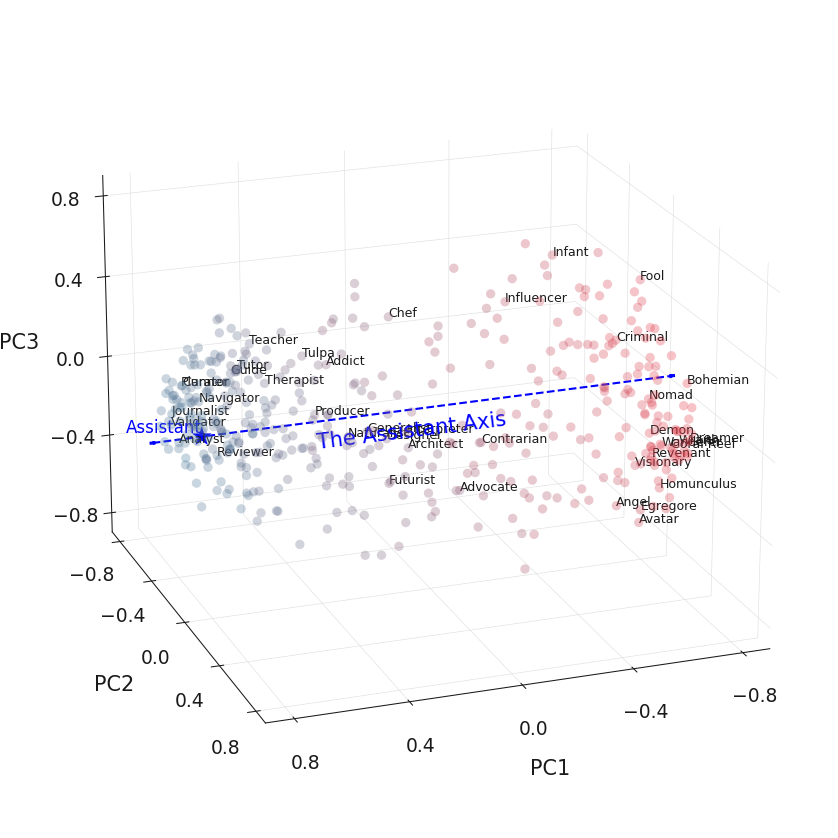

In [286]:
# Create 3D scatter plot with contrast vector as x-axis
fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(111, projection='3d')

# Axes: x=PC1, y=PC2, z=PC3
x = role_cos[:, 0]  # PC1
y = role_cos[:, 1]  # PC2
z = role_cos[:, 2]  # PC3

# Custom colormap from red to blue
from matplotlib.colors import LinearSegmentedColormap
custom_cmap = LinearSegmentedColormap.from_list('rp_asst', ['#457b9d', '#e63946'])

# Color by cosine similarity with contrast vector
contrast_norm = (role_contrast_cosine_sims - role_contrast_cosine_sims.min()) / (role_contrast_cosine_sims.max() - role_contrast_cosine_sims.min())
colors = custom_cmap(contrast_norm)

# Plot role vectors
sc = ax.scatter(x, y, z, c=colors, alpha=0.3, label='Roles')

# Add labels for selected roles
for i in indices_to_label:
    short_label = role_labels[i].split(' (')[0]
    ax.text(role_cos[i, 0], role_cos[i, 1], role_cos[i, 2],
            short_label, fontsize=6)

# Plot assistant
asst_cos = assistant_cosine_sims.numpy()[0]

# Get contrast vector direction in PC space (this is the Assistant Axis)
contrast_in_pc_space = (pc_directions @ contrast_vector).numpy()  # shape (3,)
contrast_dir = contrast_in_pc_space / np.linalg.norm(contrast_in_pc_space)  # normalize

# Calculate t values to reach x.min() and x.max()
t_min = (x.min() - asst_cos[0]) / contrast_dir[0]
t_max = (x.max() - asst_cos[0]) / contrast_dir[0]

# Draw dashed line along contrast vector direction from x.min() to x.max()
t = np.linspace(t_min, t_max, 100)
axis_line_x = asst_cos[0] + t * contrast_dir[0]
axis_line_y = asst_cos[1] + t * contrast_dir[1]
axis_line_z = asst_cos[2] + t * contrast_dir[2]
ax.plot(axis_line_x, axis_line_y, axis_line_z, '--', linewidth=1, label='Assistant Axis', c='blue')

# Add arrows at both ends of the assistant axis
arrow_scale = 0.02
# Arrow at negative end
ax.quiver(axis_line_x[0], axis_line_y[0], axis_line_z[0], 
          -contrast_dir[0]*arrow_scale, -contrast_dir[1]*arrow_scale, -contrast_dir[2]*arrow_scale,
          color='blue', arrow_length_ratio=0.5)
# Arrow at positive end
ax.quiver(axis_line_x[-1], axis_line_y[-1], axis_line_z[-1], 
          contrast_dir[0]*arrow_scale, contrast_dir[1]*arrow_scale, contrast_dir[2]*arrow_scale,
          color='blue', arrow_length_ratio=0.5)

# Text for assistant axis - at midpoint of the line, using zdir='x' for orientation
mid_idx = len(axis_line_x) // 2
ax.text(axis_line_x[mid_idx], axis_line_y[mid_idx], axis_line_z[mid_idx], 
        'The Assistant Axis', zdir='x', fontsize=10, color='blue', ha='center', va='top')

ax.scatter([asst_cos[0]], [asst_cos[1]], [asst_cos[2]],
           c='blue', marker='*', s=100, label='Assistant', edgecolors='none')
# Assistant label anchored by bottom right
ax.text(asst_cos[0], asst_cos[1], asst_cos[2], 'Assistant', fontsize=8, color='blue', ha='right', va='bottom')

# Labels
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

# Remove grid
ax.grid(True)

# Remove the gray panes (background planes)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

# Remove pane edges
ax.xaxis.pane.set_edgecolor('none')
ax.yaxis.pane.set_edgecolor('none')
ax.zaxis.pane.set_edgecolor('none')

ax.set_xticks([-0.8, -0.4, 0, 0.4, 0.8])
ax.set_yticks([-0.8, -0.4, 0, 0.4, 0.8])
ax.set_zticks([-0.8, -0.4, 0, 0.4, 0.8])

ax.set_xlim(-0.9, 0.9)
ax.set_ylim(-0.9, 0.9)
ax.set_zlim(-0.9, 0.9)

ax.view_init(elev=20, azim=70) 

plt.show()

In [287]:
from matplotlib.colors import LinearSegmentedColormap

def plot_pc_lines_grid(role_cosine_sims, role_labels, pca_results,
                       pc_configs=None,
                       assistant_cosine_sim=None,
                       figsize=(10, 8), n_extremes=5, show_histogram=True,
                       cmap_colors=None):
    """
    Plot top 3 PCs' cosine similarities in a single figure with 3 subplots.

    Args:
        role_cosine_sims: (n_roles, 3) array of cosine similarities
        role_labels: Full list of role labels with "(Somewhat RP)"/"(Fully RP)" suffixes
        pca_results: Dict with 'roles' containing 'pos_2' and 'pos_3' lists
        pc_configs: Dict mapping pc_idx -> {'include_labels': [...], 'exclude_labels': [...]}
        assistant_cosine_sim: Optional (3,) array of assistant cosine sims
        figsize: Figure size tuple
        n_extremes: Number of extremes to label on each end
        show_histogram: Whether to show histogram overlay
        cmap_colors: List/tuple of colors for gradient (can be 2+ colors), defaults to purple-teal
    """
    pc_configs = pc_configs or {i: {'include_labels': [], 'exclude_labels': []} for i in range(3)}
    
    # Default colors: purple to teal
    if cmap_colors is None:
        cmap_colors = ['#9b59b6', '#1abc9c']
    
    # Build role name lookup (maps raw name -> index)
    pos_2_roles = pca_results['roles']['pos_2']
    pos_3_roles = pca_results['roles']['pos_3']
    n_pos_2 = len(pos_2_roles)
    
    def get_role_indices(role_name):
        """Get ALL indices for a role name (can appear in both pos_2 and pos_3)."""
        indices = []
        if role_name in pos_2_roles:
            indices.append(pos_2_roles.index(role_name))
        if role_name in pos_3_roles:
            indices.append(n_pos_2 + pos_3_roles.index(role_name))
        return indices
    
    def get_short_label(idx):
        """Get the short label name (without suffix) for an index."""
        return role_labels[idx].split(' (')[0]
    
    def get_unique_extremes(sorted_indices, n_extremes, exclude_idx):
        """Get n_extremes indices with unique label names, skipping excluded and duplicates."""
        result = []
        seen_labels = set()
        for idx in sorted_indices:
            if idx in exclude_idx:
                continue
            label = get_short_label(idx)
            if label not in seen_labels:
                seen_labels.add(label)
                result.append(idx)
                if len(result) >= n_extremes:
                    break
        return result
    
    # Create gradient colormap (supports 2+ colors)
    custom_cmap = LinearSegmentedColormap.from_list('CustomGradient', list(cmap_colors))
    
    # Create figure with 3 subplots
    fig, axes = plt.subplots(3, 1, figsize=figsize)
    
    for pc_idx, ax in enumerate(axes):
        include_labels = pc_configs.get(pc_idx, {}).get('include_labels', [])
        exclude_labels = pc_configs.get(pc_idx, {}).get('exclude_labels', [])
        
        # Get projections for this PC
        projections = role_cosine_sims[:, pc_idx]
        
        # Color based on projection value (x-axis position)
        # Normalize to [0, 1] based on x-axis range (-1, 1)
        c_norm = (projections + 1) / 2  # maps [-1, 1] to [0, 1]
        colors = custom_cmap(c_norm)
        
        # Build exclude set (check both pos_2 and pos_3)
        exclude_idx = set()
        for r in exclude_labels:
            exclude_idx.update(get_role_indices(r))
        
        # Build include set
        include_idx = set()
        for r in include_labels:
            if r in pos_3_roles:
                include_idx.add(n_pos_2 + pos_3_roles.index(r))
            if r in pos_2_roles:
                include_idx.add(pos_2_roles.index(r))
        
        # Find extreme indices with unique labels
        sorted_indices = np.argsort(projections)
        low_extreme_indices = get_unique_extremes(sorted_indices, n_extremes, exclude_idx)
        high_extreme_indices = get_unique_extremes(sorted_indices[::-1], n_extremes, exclude_idx)
        
        # Build labels to show: extremes + includes (deduped by label name)
        seen_labels = set()
        low_to_label = []
        for idx in low_extreme_indices:
            label = get_short_label(idx)
            if label not in seen_labels:
                seen_labels.add(label)
                low_to_label.append(idx)
        # Add includes on the low side
        for idx in include_idx:
            if projections[idx] < 0 and idx not in exclude_idx:
                label = get_short_label(idx)
                if label not in seen_labels:
                    seen_labels.add(label)
                    low_to_label.append(idx)
        
        seen_labels_high = set()
        high_to_label = []
        for idx in high_extreme_indices:
            label = get_short_label(idx)
            if label not in seen_labels_high:
                seen_labels_high.add(label)
                high_to_label.append(idx)
        # Add includes on the high side
        for idx in include_idx:
            if projections[idx] >= 0 and idx not in exclude_idx:
                label = get_short_label(idx)
                if label not in seen_labels_high:
                    seen_labels_high.add(label)
                    high_to_label.append(idx)
        
        # Plot all points with gradient colors
        y_pos = np.zeros_like(projections)
        ax.scatter(projections, y_pos, c=colors, marker='o', s=40, 
                   alpha=0.6, edgecolors='none', zorder=3)
        
        # Add histogram overlay
        if show_histogram:
            hist_counts, bin_edges = np.histogram(projections, bins=30, density=True)
            bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
            bin_width = bin_edges[1] - bin_edges[0]
            
            hist_scale = 0.4
            scaled_heights = hist_counts * hist_scale
            
            # Color histogram bars based on bin position
            bin_norm = (bin_centers + 1) / 2  # maps [-1, 1] to [0, 1]
            bin_norm = np.clip(bin_norm, 0, 1)
            bin_colors = custom_cmap(bin_norm)
            ax.bar(bin_centers, scaled_heights, width=bin_width, 
                   alpha=0.3, color=bin_colors, edgecolor='none', zorder=1)
        
        # Add Assistant if provided
        if assistant_cosine_sim is not None:
            asst_val = assistant_cosine_sim[pc_idx]
            ax.axvline(x=asst_val, color='blue', linestyle='--', linewidth=1, alpha=0.9, zorder=2)
            ax.scatter([asst_val], [0], c='blue', marker='*', s=300, alpha=1.0,
                    linewidth=2, zorder=5)
            ax.text(asst_val, 0.55, 'Assistant', ha='center', va='bottom', fontsize=10,
                    color='blue', alpha=0.9)
        
        # Fixed y positions with same spacing above and below
        y_above = [0.25, 0.35, 0.45]
        y_below = [-0.25, -0.35, -0.45]
        
        # Add labels for low extremes (left side) - alternate above/below
        for i, idx in enumerate(low_to_label):
            label = get_short_label(idx)
            x_pos = projections[idx]
            
            if i % 2 == 0:  # above
                y_label = y_above[i // 2] if i // 2 < len(y_above) else y_above[-1]
                va = 'bottom'
                line_end = y_label - 0.02
            else:  # below
                y_label = y_below[i // 2] if i // 2 < len(y_below) else y_below[-1]
                va = 'top'
                line_end = y_label + 0.02
            
            # Draw leader line
            ax.plot([x_pos, x_pos], [0.02 if y_label > 0 else -0.02, line_end], '-', color='gray', 
                    alpha=0.4, linewidth=0.8, zorder=1)
            
            ax.text(x_pos, y_label, label, ha='center', va=va, fontsize=9, zorder=4)
        
        # Add labels for high extremes (right side) - alternate above/below
        for i, idx in enumerate(high_to_label):
            label = get_short_label(idx)
            x_pos = projections[idx]
            
            if i % 2 == 0:  # above
                y_label = y_above[i // 2] if i // 2 < len(y_above) else y_above[-1]
                va = 'bottom'
                line_end = y_label - 0.02
            else:  # below
                y_label = y_below[i // 2] if i // 2 < len(y_below) else y_below[-1]
                va = 'top'
                line_end = y_label + 0.02
            
            # Draw leader line  
            ax.plot([x_pos, x_pos], [0.02 if y_label > 0 else -0.02, line_end], '-', color='gray', 
                    alpha=0.4, linewidth=0.8, zorder=1)
            
            ax.text(x_pos, y_label, label, ha='center', va=va, fontsize=9, zorder=4)
        
        # Style
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_position('zero')
        ax.axhline(y=0, color='black', linestyle='-', linewidth=2, zorder=1)
        
        ax.tick_params(axis='x', length=12, width=1.5, pad=10)
        ax.tick_params(axis='y', length=0, width=0)
        ax.set_yticks([])
        ax.set_xticks([-0.8, -0.4, 0, 0.4, 0.8])
        ax.set_ylim(-0.5, 0.5)
        ax.set_xlim(-1, 1)
        ax.grid(False)
        # PC title as left-aligned title above subplot
        ax.set_title(f'PC{pc_idx + 1}', fontsize=12, fontweight='bold', loc='left')
    
    plt.tight_layout()
    return fig

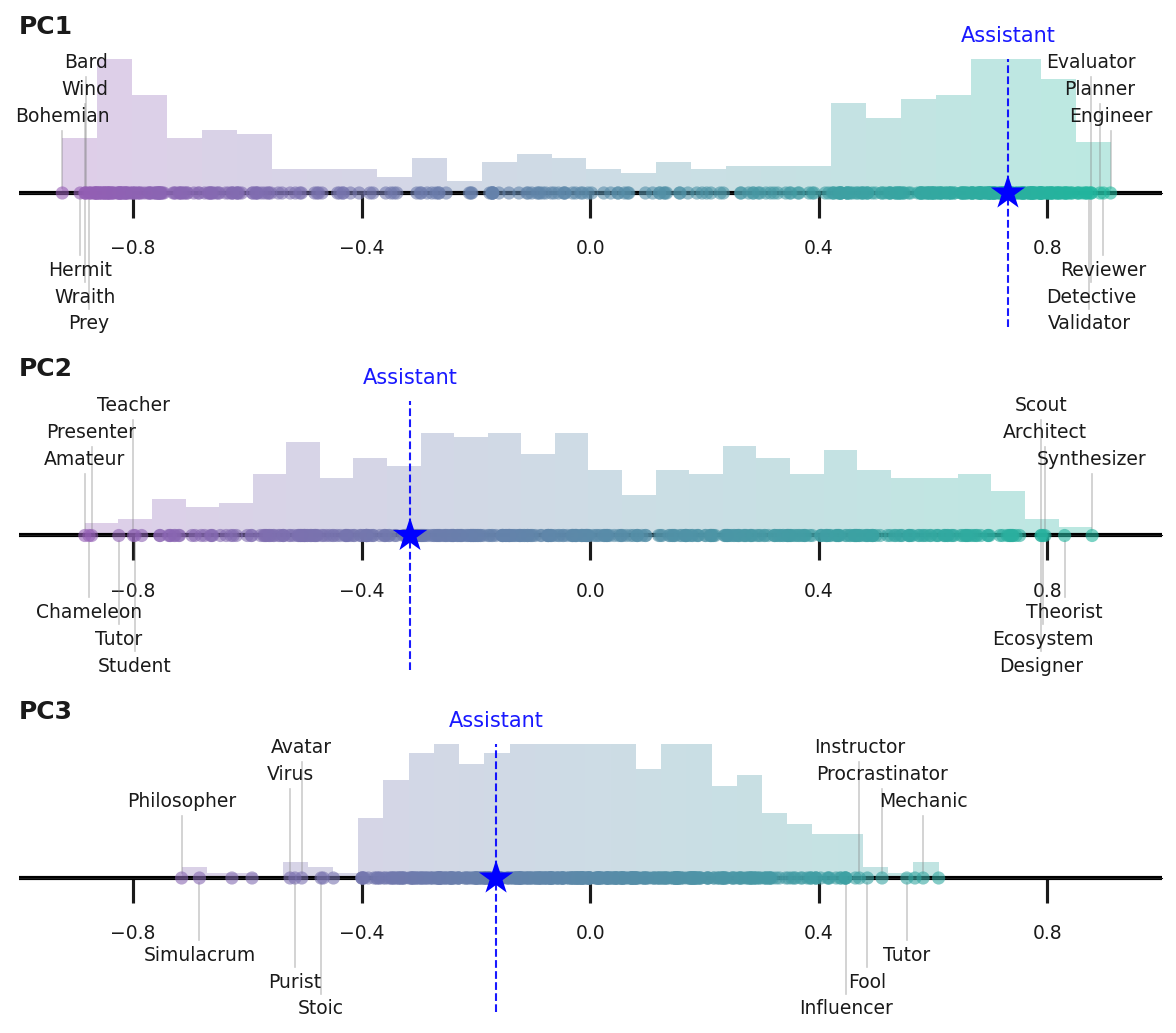

In [288]:
# Configure labels per PC - adjust these lists as needed
# include_labels: roles from pos_3 to label between the extremes
# exclude_labels: roles from pos_2 or pos_3 to never label

pc_config = {
    0: {  # PC1
        'exclude_labels': ['infant', 'toddler', 'adolescent'],
    },
    1: {  # PC2
        'exclude_labels': ['infant', 'toddler', 'adolescent'],
    },
    2: {  # PC3
        'exclude_labels': ['infant', 'toddler', 'adolescent'],
        
    },
}

# Generate single plot with 3 PC subplots for roles
asst_cos = assistant_cosine_sims.numpy()[0]

fig = plot_pc_lines_grid(
    role_cos, role_labels, pca_results,
    pc_configs=pc_config,
    assistant_cosine_sim=asst_cos,
    figsize=(8, 7),
    n_extremes=6,
    show_histogram=True,
)
plt.savefig(f"{plot_output_dir}/roles_pcs_line.pdf", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Load and plot traits PCA (top 3 PCs)
traits_pca_results = torch.load(f"{dir}/traits_240/pca/layer{layer}_mean_pos-neg50.pt", weights_only=False)

# Get trait labels and vectors
trait_names = traits_pca_results['traits']['pos_neg_50']
trait_labels = [name.replace('_', ' ').title() for name in trait_names]
trait_vectors = traits_pca_results['vectors']['pos_neg_50']


In [ ]:

# Get PC directions from traits PCA
traits_pc_directions = torch.tensor(traits_pca_results['pca'].components_[:3]).float()
traits_pc_directions = F.normalize(traits_pc_directions, dim=1)

if model_short == "qwen-3-32b":
    traits_pc_directions[0] = traits_pc_directions[0] * -1
    #traits_pc_directions[1] = traits_pc_directions[1] * -1
    #traits_pc_directions[2] = traits_pc_directions[2] * -1
if model_short == "gemma-2-27b":
    traits_pc_directions[0] = traits_pc_directions[0] * -1
    #traits_pc_directions[1] = traits_pc_directions[1] * -1
    traits_pc_directions[2] = traits_pc_directions[2] * -1


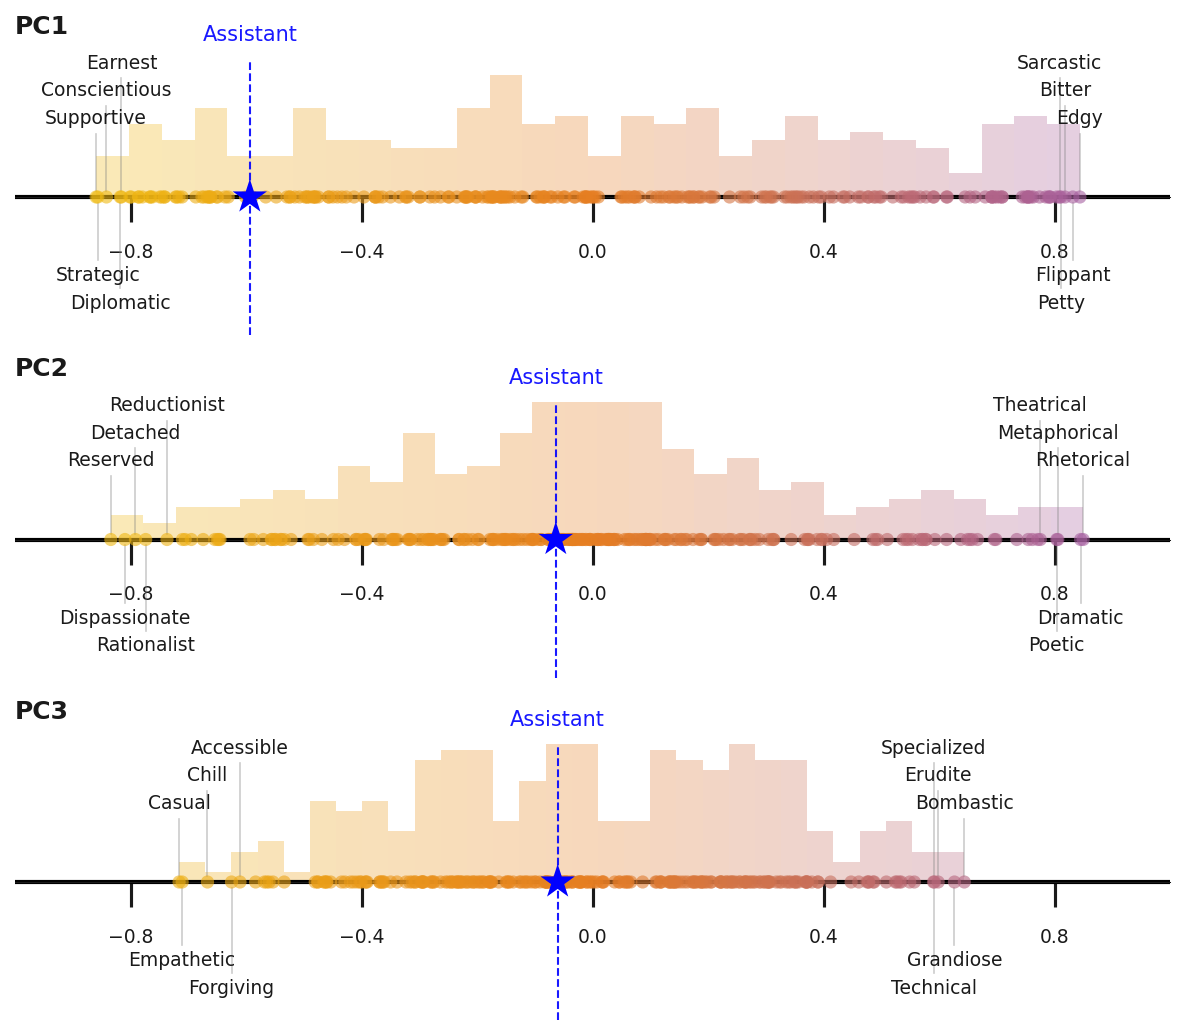

In [ ]:

# Stack trait vectors at the target layer
trait_vectors_at_layer = torch.stack([v[layer] for v in trait_vectors]).float()

# Scale trait vectors
trait_vectors_scaled = torch.tensor(traits_pca_results['scaler'].transform(trait_vectors_at_layer)).float()

# Normalize for cosine similarity
trait_vectors_norm = F.normalize(trait_vectors_scaled, dim=1)

# Compute cosine similarities with PC directions: (n_traits, 3)
trait_cosine_sims = (trait_vectors_norm @ traits_pc_directions.T).numpy()

# Compute assistant cosine similarity with trait PCs
assistant_traits_scaled = torch.tensor(traits_pca_results['scaler'].transform(assistant_layer_activation)).float()
assistant_traits_norm = F.normalize(assistant_traits_scaled, dim=1)
assistant_traits_cosine_sims = (assistant_traits_norm @ traits_pc_directions.T).numpy()[0]

# Build a pca_results dict compatible with plot_pc_lines_grid
traits_pca_for_plot = {
    'roles': {
        'pos_2': list(trait_names),  # use trait names for lookup
        'pos_3': [],  # empty
    }
}

# Configure labels per PC for traits (adjust as needed)
traits_pc_config = {
    0: {'include_labels': [], 'exclude_labels': []},
    1: {'include_labels': [], 'exclude_labels': []},
    2: {'include_labels': [], 'exclude_labels': []},
}

# Generate single plot with 3 PC subplots for traits (yellow → orange → magenta)
fig = plot_pc_lines_grid(
    trait_cosine_sims, trait_labels, traits_pca_for_plot,
    pc_configs=traits_pc_config,
    assistant_cosine_sim=assistant_traits_cosine_sims,
    figsize=(8, 7),
    n_extremes=5,
    show_histogram=True,
    cmap_colors=['#f1c40f', '#e67e22', '#9b59b6']  # yellow → orange → magenta
)
plt.savefig(f"{plot_output_dir}/traits_pcs_line.pdf", dpi=300, bbox_inches='tight')
plt.show()